<a href="https://colab.research.google.com/github/Marlrero/AI_PrimaryEducation/blob/main/bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Keras RNN으로 Bitcoin 시세 예측

#### 1. import package & set hyperparameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [2]:
# hyperparameters
MY_PAST = 5
MY_HIDDEN = 256
MY_EPOCH = 10

#### 2. load dataset & data preprocessing

In [3]:
rawDB = pd.read_csv('/content/drive/MyDrive/dataset/BTC-USD.csv',
                    header=0, # 헤더를 데이터로 인식하는 것을 방지함
                    usecols=['Date', 'Close'], # Date와 Close 컬럼을 사용
                    parse_dates=True, # 날짜에 대해 Parsing 허용
                    index_col='Date')

rawDB.head(10)

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
2014-09-22,402.152008
2014-09-23,435.790985
2014-09-24,423.204987
2014-09-25,411.574005


In [4]:
rawDB.describe()

,Close
count,2309.000000
mean,5080.521166
std,5268.144533
min,178.102997
25%,446.721985
50%,3906.717285
75%,8510.379883
max,40797.609375


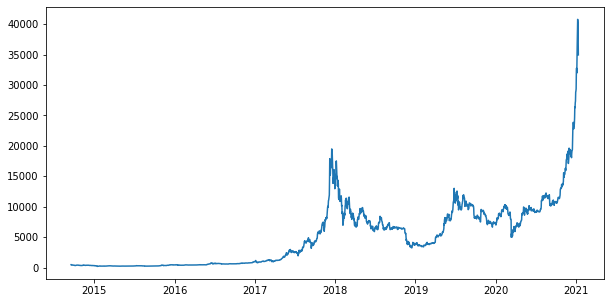

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(rawDB)
plt.show()

In [6]:
# MinMax Normalization
scaler = MinMaxScaler() # (data - min) / (|max - min|)
scaledDB = scaler.fit_transform(rawDB)

print("Origin data shape:", type(rawDB))
print("Normalized data shape:", type(scaledDB))

Origin data shape: <class 'pandas.core.frame.DataFrame'>
Normalized data shape: <class 'numpy.ndarray'>


In [7]:
# pandas.DataFrame -> numpy.ndarray
summary = pd.DataFrame(scaledDB)
print(summary.head(10))
print(summary.describe())

          0
0  0.006874
1  0.006065
2  0.005335
3  0.005682
4  0.005434
5  0.005516
6  0.006344
7  0.006034
8  0.005748
9  0.005572
                 0
count  2309.000000
mean      0.120691
std       0.129695
min       0.000000
25%       0.006613
50%       0.091794
75%       0.205130
max       1.000000


In [8]:
'''
# 입력, 타깃 분할
X_train, Y_train = [], []
total = len(scaledDB)

# 시계열 데이터를 6개로 묶음
  전체: 2309개
  0 ~ 5, 1 ~ 6, 2 ~ 7, ... , 2303 ~ 2308(마지막)
  ----   전체: 2304개 묶음 ----
  -- X_train은 1개의 묶음 안에 5개 데이터
  -- Y_train은 1개의 묶음 안에 마지막(1개) 데이터
for i in range(total - MY_PAST): # 2309 - 6 = 2303까지 반복해야 함
  input = scaledDB[i:i + MY_PAST, :] # 0~4번째 (훈련)
  X_train.append(input)
  output = scaledDB[i + MY_PAST, :] # 5번째 (타깃)
  Y_train.append(output)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

print(total, X_train.shape, Y_train.shape)
'''

'\n# 입력, 타깃 분할\nX_train, Y_train = [], []\ntotal = len(scaledDB)\n\n# 시계열 데이터를 6개로 묶음\n  전체: 2309개\n  0 ~ 5, 1 ~ 6, 2 ~ 7, ... , 2303 ~ 2308(마지막)\n  ----   전체: 2304개 묶음 ----\n  -- X_train은 1개의 묶음 안에 5개 데이터\n  -- Y_train은 1개의 묶음 안에 마지막(1개) 데이터\nfor i in range(total - MY_PAST): # 2309 - 6 = 2303까지 반복해야 함\n  input = scaledDB[i:i + MY_PAST, :] # 0~4번째 (훈련)\n  X_train.append(input)\n  output = scaledDB[i + MY_PAST, :] # 5번째 (타깃)\n  Y_train.append(output)\n\nX_train = np.array(X_train)\nY_train = np.array(Y_train)\n\nprint(total, X_train.shape, Y_train.shape)\n'

* 왜 값에 대해 단독 차원을 가지고 있는가?
  - LSTM은 3차원 데이터를 필요로 하기 때문임!

In [9]:
# 시계열 데이터를 6개 묶음으로 분할 (위랑 동일 코드)
data = []
print(len(scaledDB))
for i in range(len(scaledDB) - MY_PAST):
  data.append(scaledDB[i: i+MY_PAST+1])

print('한 묶음의 크기 :',len(data[0]))
print('총 묶음의 수:',len(data))
print('첫번째 묶음 내용\n', data[0])

data = np.array(data)
#np.random.shuffle(data) # 섞음 (섞으면 오늘 예측 불가)

X_data = data[:, :MY_PAST]
Y_data = data[:, -1]

print('입력 데이터 모양:',X_data.shape)
print('출력 데이터 모양:',Y_data.shape)

X_train, Y_train = X_data, Y_data

2309
한 묶음의 크기 : 6
총 묶음의 수: 2304
첫번째 묶음 내용
 [[0.00687431]
 [0.0060645 ]
 [0.0053347 ]
 [0.00568202]
 [0.00543379]
 [0.0055158 ]]
입력 데이터 모양: (2304, 5, 1)
출력 데이터 모양: (2304, 1)


#### 3. RNN(LSTM) Model & Learning

* 가격(숫자)을 예측하는 것인데 마지막 Activation을 할 필요가 없음. 있는 그대로 가지고 오는 것이 좋음.
  - 항등 함수(Identity function)을 사용한다고 말함.

In [10]:
model = Sequential(name='RNN_LSTM_0')
model.add(LSTM(name='LSTM_0', units=MY_HIDDEN, input_shape=(MY_PAST, 1)))
model.add(Dense(name='FC_0', units=1)) # Regression activation -> identity function
model.summary()

Model: "RNN_LSTM_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_0 (LSTM)                (None, 256)               264192    
_________________________________________________________________
FC_0 (Dense)                 (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam', loss='mse')

begin = time()
model.fit(x=X_train, y=Y_train, epochs=MY_EPOCH, verbose=2)
end = time()
print("Learning time: {:.2f}sec".format(end - begin))

Epoch 1/10
72/72 - 3s - loss: 0.0020
Epoch 2/10
72/72 - 0s - loss: 2.3975e-04
Epoch 3/10
72/72 - 0s - loss: 1.8870e-04
Epoch 4/10
72/72 - 0s - loss: 2.1120e-04
Epoch 5/10
72/72 - 0s - loss: 2.4121e-04
Epoch 6/10
72/72 - 0s - loss: 1.8604e-04
Epoch 7/10
72/72 - 0s - loss: 1.9441e-04
Epoch 8/10
72/72 - 0s - loss: 2.0467e-04
Epoch 9/10
72/72 - 0s - loss: 2.1625e-04
Epoch 10/10
72/72 - 0s - loss: 1.9593e-04
Learning time: 4.50sec


#### 4. Model Prediction

In [12]:
#최근 시세 출력
print('최근 6일 비트코인 시세:')
print(rawDB.tail(MY_PAST + 1))

최근 6일 비트코인 시세:
                   Close
Date                    
2021-01-06  36824.363281
2021-01-07  39371.042969
2021-01-08  40797.609375
2021-01-09  40254.546875
2021-01-10  38356.441406
2021-01-11  34954.035156


In [13]:
# 오늘 비트코인 가격 예측하기
last = X_train[-1] # 맨 마지막 행
#last가 정상적으로 위에 셸 처럼 복구되었는지 확인하는 코드
#last = scaler.inverse_transform(last)
#print(last)

# 3차원으로 증가 (배치 정보 추가)
print(last.shape) # 5, 1
last = np.expand_dims(last, axis=0)
# 아래 코드도 동일한 코드
#last = last.reshape(1, 5, 1)
print(last.shape) # 1, 5, 1

pred = model.predict(last)
pred = scaler.inverse_transform(pred)
print("Today Predicted Bitcoin:", pred, "dollar")

truth = Y_train[-1] # 맨 마지막 행
truth = np.expand_dims(truth, axis=0)
truth = scaler.inverse_transform(truth)
print("Today Truth Bitcoin:", truth, "dollar")
print("Error:", np.abs(truth[0][0] - pred[0][0]))

(5, 1)
(1, 5, 1)
Today Predicted Bitcoin: [[41730.273]] dollar
Today Truth Bitcoin: [[34954.035156]] dollar
Error: 6776.238281500002


In [14]:
# 내일 비트코인 가격 예측하기
tmp = rawDB.to_numpy()
tom = tmp[len(tmp) - MY_PAST:] # 마지막 5개 행
print(tom)

tom = scaler.fit_transform(tom)
tom = np.expand_dims(tom, axis=0)

pred = model.predict(tom)
pred = scaler.inverse_transform(pred)
print("Tomorrow:", pred, "dollar")

[[39371.042969]
 [40797.609375]
 [40254.546875]
 [38356.441406]
 [34954.035156]]
Tomorrow: [[38886.652]] dollar
